# Napelem termelés előrejelzés

In [1]:
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
%matplotlib inline

Beolvastam a teljes adathalmazt és összekapcsoltam a magyarázó változókkal

In [2]:
# Reading the data
PATH_TO_TRAIN = '../data/raw/train15.csv'
PATH_TO_PREDICTORS = '../data/raw/predictors15.csv'
INDEX_COLUMN = 'TIMESTAMP'
TARGET_COLUMN = 'POWER'
df_power = pd.read_csv(PATH_TO_TRAIN)
df_features = pd.read_csv(PATH_TO_PREDICTORS)
df_original = df_power.merge(df_features, how='left', on=[INDEX_COLUMN,'ZONEID'])

Megnéztem, hogy néz ki az adat.

In [3]:
df_original.describe()

,ZONEID,POWER,VAR78,VAR79,VAR134,VAR157,VAR164,VAR165,VAR166,VAR167,VAR169,VAR175,VAR178,VAR228
count,56952.000000,56952.000000,56952.000000,56952.000000,56952.000000,56952.000000,56952.000000,56952.000000,56952.000000,56952.000000,5.695200e+04,5.695200e+04,5.695200e+04,56952.000000
mean,2.000000,0.186872,0.041470,0.016408,93807.236996,67.610793,0.436522,0.738276,-0.257701,285.435328,1.250545e+07,1.382187e+07,1.462089e+07,0.000997
std,0.816504,0.274926,0.122040,0.050371,1106.902058,20.336232,0.400015,2.452712,1.983266,7.051843,6.593117e+06,7.755640e+06,7.049271e+06,0.003445
min,1.000000,0.000000,0.000000,0.000000,90345.875000,6.348233,0.000000,-8.908603,-8.404230,269.436279,1.147127e+05,8.216176e+05,6.465230e+05,0.000000
25%,1.000000,0.000000,0.000000,0.000000,92903.000000,52.359467,0.012650,-0.775085,-1.594760,280.142761,7.616334e+06,7.271122e+06,9.568199e+06,0.000000
50%,2.000000,0.003117,0.002919,0.000117,94008.093750,70.545609,0.353457,0.368076,-0.411445,284.784790,1.141026e+07,1.368581e+07,1.342308e+07,0.000000
75%,3.000000,0.333608,0.033479,0.007191,94668.203125,84.952175,0.884594,2.143609,0.944802,290.000977,1.742018e+07,2.002196e+07,2.002346e+07,0.000257
max,3.000000,1.003550,4.103422,0.820470,96317.125000,102.838364,1.000008,13.056718,10.710998,310.458496,3.462558e+07,3.467366e+07,3.772200e+07,0.055961


In [4]:
df_original.head()

,ZONEID,TIMESTAMP,POWER,VAR78,VAR79,VAR134,VAR157,VAR164,VAR165,VAR166,VAR167,VAR169,VAR175,VAR178,VAR228
0,1,20120401 01:00,0.754103,0.001967,0.003609,94843.6250,60.221909,0.244601,1.039334,-2.503039,294.448486,2577830.0,1202532.0,2861797.0,0.000000
1,1,20120401 02:00,0.555000,0.005524,0.033575,94757.9375,54.678604,0.457138,2.482865,-2.993330,295.651367,5356093.0,2446757.0,5949378.0,0.000000
2,1,20120401 03:00,0.438397,0.030113,0.132009,94732.8125,61.294891,0.771429,3.339867,-1.982535,294.454590,7921788.0,3681336.0,8939176.0,0.001341
3,1,20120401 04:00,0.145449,0.057167,0.110645,94704.0625,67.775284,0.965866,3.106102,-1.446051,293.261475,9860520.0,4921504.0,11331679.0,0.002501
4,1,20120401 05:00,0.111987,0.051027,0.189560,94675.0000,70.172989,0.944669,2.601146,-1.904493,292.732910,11143097.0,6254380.0,13105558.0,0.003331


In [5]:
 df_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56952 entries, 0 to 56951
Data columns (total 15 columns):
ZONEID       56952 non-null int64
TIMESTAMP    56952 non-null object
POWER        56952 non-null float64
VAR78        56952 non-null float64
VAR79        56952 non-null float64
VAR134       56952 non-null float64
VAR157       56952 non-null float64
VAR164       56952 non-null float64
VAR165       56952 non-null float64
VAR166       56952 non-null float64
VAR167       56952 non-null float64
VAR169       56952 non-null float64
VAR175       56952 non-null float64
VAR178       56952 non-null float64
VAR228       56952 non-null float64
dtypes: float64(13), int64(1), object(1)
memory usage: 7.0+ MB


A fentiekből kiolvasva látsztik, hogy a timestamp nem dateTime típusú, illetve az is hogy milyen formátumban van. Ezek alapján át lehet konvertálni. Ami még látszik belőle, hogy az egyes mérési eredmények óránként vannak megadva.

In [6]:
df = df_original.copy()
DATE_FORMAT = '%Y%m%d %H:%M'
dateparse = lambda x: pd.datetime.strptime(x, DATE_FORMAT)
df[INDEX_COLUMN] = df[INDEX_COLUMN].apply(dateparse)

In [7]:
df[INDEX_COLUMN].head(1)

0   2012-04-01 01:00:00
Name: TIMESTAMP, dtype: datetime64[ns]

Amit még érdemes átalakítani , az a feature változók elnevezése. VARXY elég nehezen értelmezhető, ezért átneveztem őket a feladaleírásban szereplő nevekkel.

In [8]:
column_mapping = {"VAR78":"LIQUID_WATER", "VAR79": "ICE_WATER",  "VAR134":"SURFACE_PRESSURE","VAR157":"RELATIVE_HUMIDITY","VAR164":"TOTAL_CLOUD_COVER","VAR165":"WIND_U","VAR166":"WIND_V","VAR167":"TEMPERATURE","VAR169":"SOLAR_RAD","VAR175":"TERMAL_RAD","VAR178":"TOP_NET_SOLAR_RAD","VAR228":"TOTAL_PRECIPATION"}
df = df.rename(index=str, columns=column_mapping)
print(df.columns)

Index(['ZONEID', 'TIMESTAMP', 'POWER', 'LIQUID_WATER', 'ICE_WATER',
       'SURFACE_PRESSURE', 'RELATIVE_HUMIDITY', 'TOTAL_CLOUD_COVER', 'WIND_U',
       'WIND_V', 'TEMPERATURE', 'SOLAR_RAD', 'TERMAL_RAD', 'TOP_NET_SOLAR_RAD',
       'TOTAL_PRECIPATION'],
      dtype='object')


Megnéztem zónánként milyen az eloszlása a célváltozónak

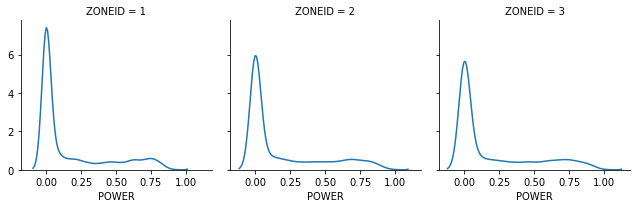

In [9]:
g = sns.FacetGrid(df, col="ZONEID")
g.map(sns.kdeplot, TARGET_COLUMN)

Mivel nagyjából egyformának tűnik, azt leszámítva, hogy az első zónában kicsit több érték van a 0 közelében, így úgy döntöttem az elemzési részben elég csak egyet vizsgálnom közülük első körben. Modell építésnél is szerintem külön modellt fogok rájuk építeni.

In [10]:
df = df[df.ZONEID == 1].drop('ZONEID',axis=1)
#df2 = df[df.ZONEID == 2].drop('ZONEID',axis=1)
#df3 = df[df.ZONEID == 3].drop('ZONEID',axis=1)

A továbbiakban felveszem a timestampet indexnek hogy a megjelítésnél jobban látszon a célváltozó időbeli változása.

In [11]:
df = df.set_index(INDEX_COLUMN)

Mivel óránkénti adatunk van, ezért az alábbi módon tudjuk definiálni, a hónapot, hetet, évet.

In [12]:
ONE_DAY = 24
ONE_WEEK = 7 * ONE_DAY
ONE_MONTH = 30 * ONE_DAY
ONE_YEAR = 365 * ONE_DAY

Megnéztem napi, illetve heti szinten hogyan változik a célváltozó, ebből az látszik, hogy van egy napi szintű szezonalitása a célváltozónak

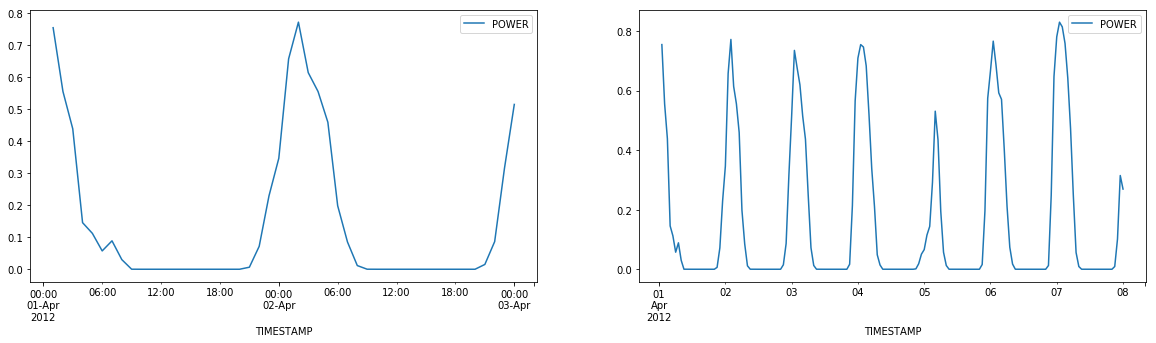

In [13]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
df[:2*ONE_DAY].plot(y=TARGET_COLUMN,ax=ax[0])
df[:ONE_WEEK].plot(y=TARGET_COLUMN,figsize=(20,5),ax=ax[1])

Ez után megnéztem, ha más felbontásban nézem az adatot (napi/havi/fél éves), akkor milyen mintát lehet benne felfedezni.

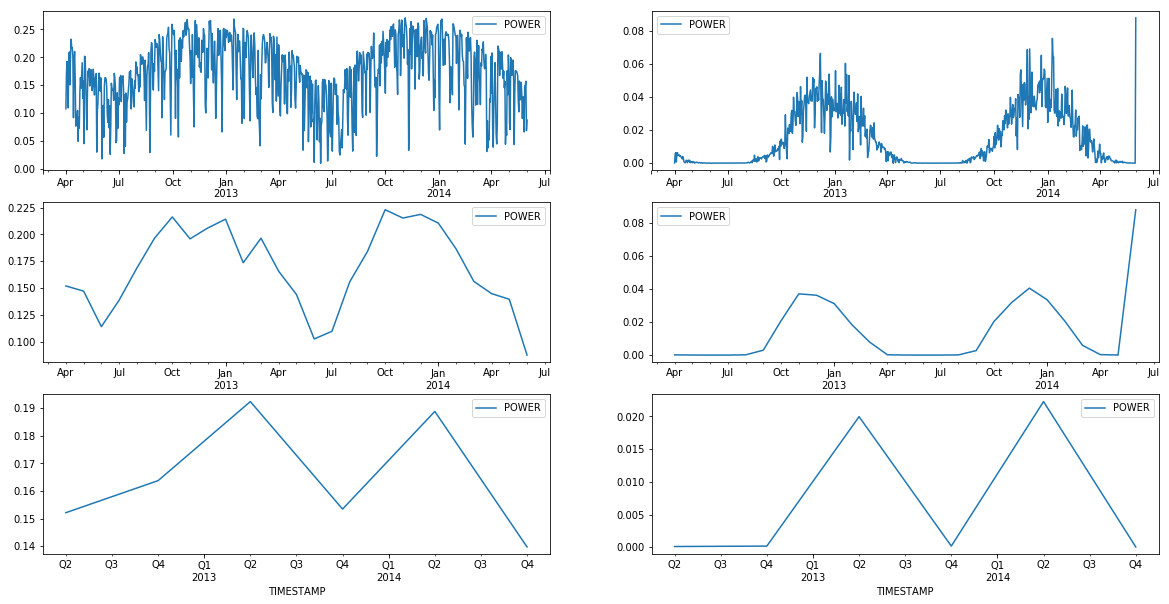

In [14]:
power_by_day = df.resample('D')
power_by_month = df.resample('M')
power_by_semester = df.resample('6M')

fig, ax = plt.subplots(3,2,figsize=(20,10))

power_by_day.mean().plot(y='POWER',ax = ax[0][0])
power_by_day.median().plot(y='POWER', ax =ax[0][1])
power_by_month.mean().plot(y='POWER', ax =ax[1][0])
power_by_month.median().plot(y='POWER', ax =ax[1][1])
power_by_semester.mean().plot(y='POWER', ax =ax[2][0])
power_by_semester.median().plot(y='POWER', ax =ax[2][1])

Innen az látszik, hogy a napi szezonalitáson kívül, van egy éves szezonalitása is. Ez elég magától értetődő, ha jobban belegondolunk, mivel napelemek termelését nézzük, ez főleg a napsugárzástól függ. Így a napi szezonalitás magyarázható azzal, hogy van este és nappal, az éves pedig azzal hogy télen kevesebbet és gyengébben süt a nap, mint nyáron.

A következőekben az adat stacionárius jellegát vizsgálom, adott felbontásokra.

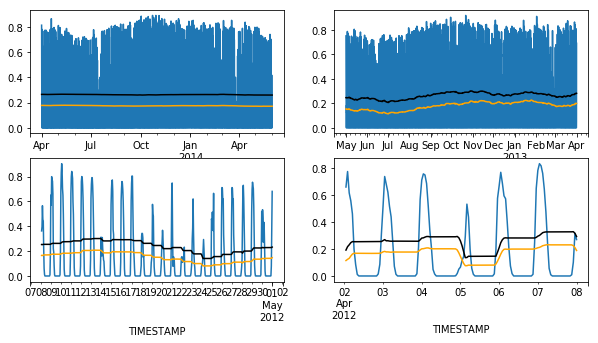

In [15]:
fig, ax = plt.subplots(2,2,figsize=(10,5))
#power_by_day.sum()["POWER"].plot()
df.POWER[ONE_YEAR:].plot(ax=ax[0][0])
df.POWER.rolling(window=ONE_YEAR).mean()[ONE_YEAR:].plot(color="orange",ax=ax[0][0])
df.POWER.rolling(window=ONE_YEAR).std()[ONE_YEAR:].plot(color="black",ax=ax[0][0])

df.POWER[ONE_MONTH:ONE_YEAR].plot(ax=ax[0][1])
df.POWER.rolling(window=ONE_MONTH).mean()[ONE_MONTH:ONE_YEAR].plot(color="orange",ax=ax[0][1])
df.POWER.rolling(window=ONE_MONTH).std()[ONE_MONTH:ONE_YEAR].plot(color="black",ax=ax[0][1])

df.POWER[ONE_WEEK:ONE_MONTH].plot(ax=ax[1][0])
df.POWER.rolling(window=ONE_WEEK).mean()[ONE_WEEK:ONE_MONTH].plot(color="orange",ax=ax[1][0])
df.POWER.rolling(window=ONE_WEEK).std()[ONE_WEEK:ONE_MONTH].plot(color="black",ax=ax[1][0])

df.POWER[ONE_DAY:ONE_WEEK].plot(ax=ax[1][1])
df.POWER.rolling(window=ONE_DAY).mean()[ONE_DAY:ONE_WEEK].plot(color="orange",ax=ax[1][1])
df.POWER.rolling(window=ONE_DAY).std()[ONE_DAY:ONE_WEEK].plot(color="black",ax=ax[1][1])

Éves szinten nézve stacionárius, más felbontásban kevésbé.

Ezután megvizsgáltam, hogy statisztikailag milyen komponensekből áll az adat.

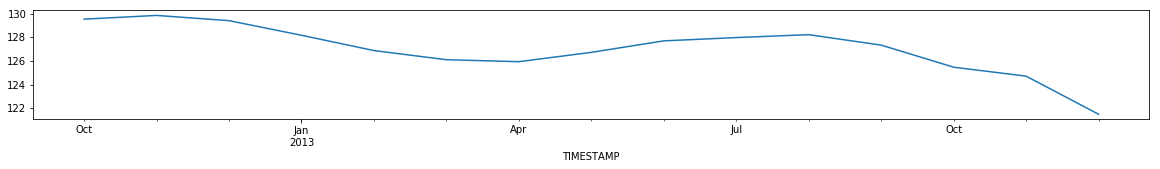

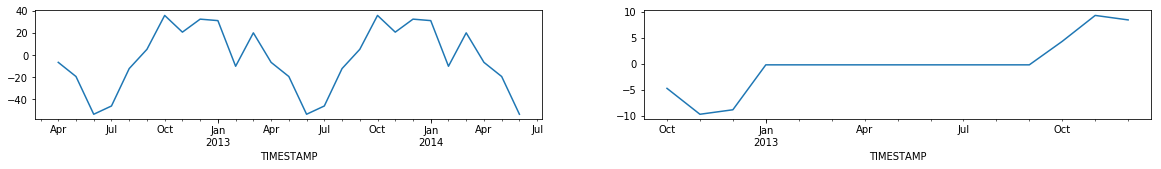

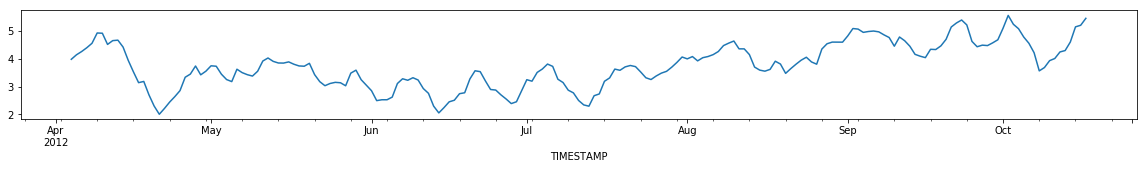

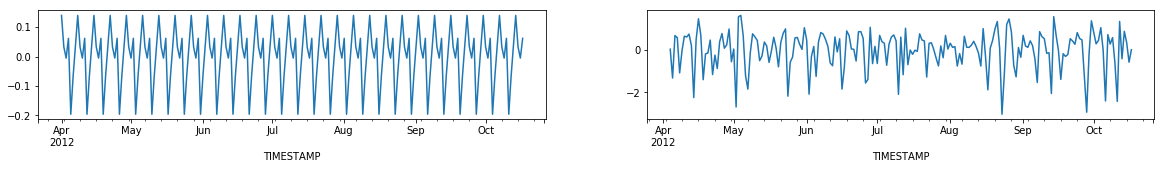

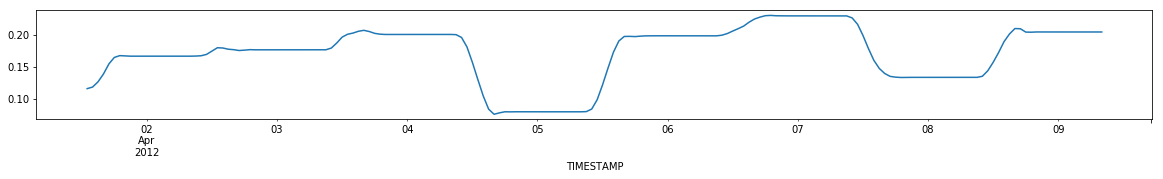

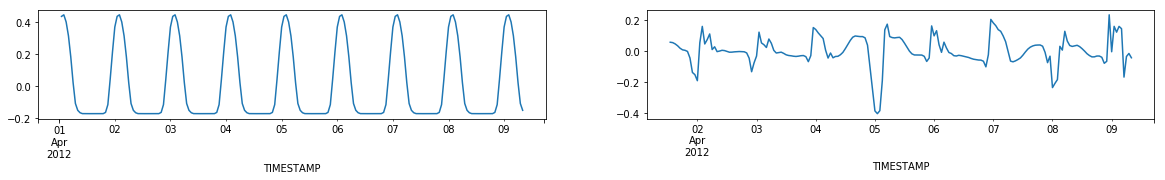

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(power_by_month.sum().POWER)
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid


fig, ax = plt.subplots(figsize = (20,2))
trend[:200].plot(ax=ax)
fig, ax = plt.subplots(1,2,figsize = (20,2))
seasonality[:200].plot(ax=ax[0])
residual[:200].plot(ax=ax[1])

decomposition = seasonal_decompose(power_by_day.sum().POWER)
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid


fig, ax = plt.subplots(figsize = (20,2))
trend[:200].plot(ax=ax)
fig, ax = plt.subplots(1,2,figsize = (20,2))
seasonality[:200].plot(ax=ax[0])
residual[:200].plot(ax=ax[1])


decomposition = seasonal_decompose(df.POWER)
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid


fig, ax = plt.subplots(figsize = (20,2))
trend[:200].plot(ax=ax)
fig, ax = plt.subplots(1,2,figsize = (20,2))
seasonality[:200].plot(ax=ax[0])
residual[:200].plot(ax=ax[1])

Ebből látszik, hogy elég erős a napi szintű szezonalitása. Trendről sok mindent nem lehet megállapítani, illetve főleg azt hogy nincs legalábbis napi szinten nincs.

## Autokorreláció

Ez után megnéztem, hogy milyen a korreláció a termelés mostani és jövő beli értékei között.

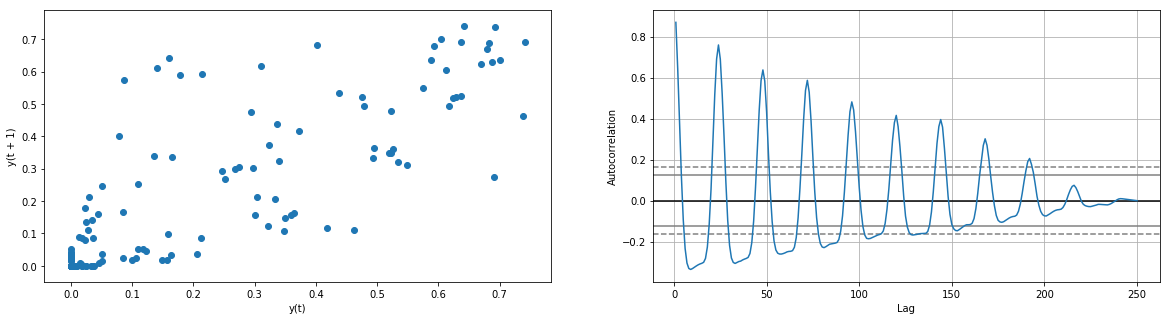

In [17]:
fig, ax = plt.subplots(1,2 ,figsize=(20,5))
lag_plot(df['POWER'].tail(250),ax=ax[0])
autocorrelation_plot(df['POWER'].tail(250),ax=ax[1])

Innen látszik, hogy van kap0csolat a kettő között. A második diagrammról leolvasható, hogy kb. az 50.lag után kezd jelentéktelenebb lenni a kapcsolat, ami 2 napot jelent.

Ez után megnéztem, milyen a kapcsolat komponensenként.

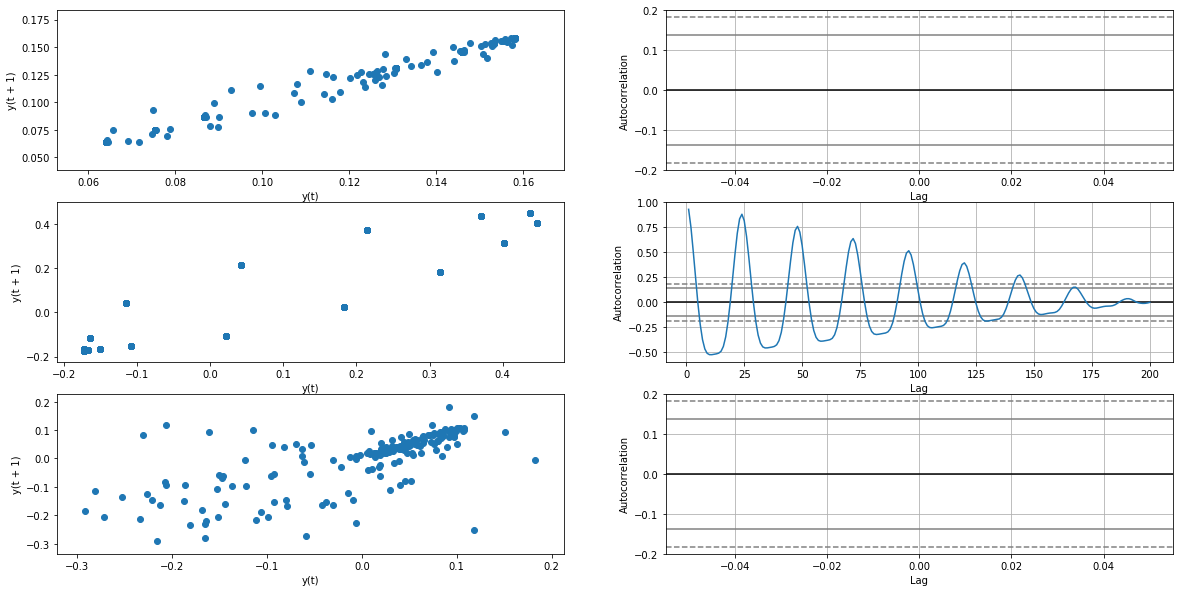

In [18]:
fig, ax = plt.subplots(3,2 ,figsize=(20,10))
lag_plot(trend.tail(200),ax=ax[0][0])
autocorrelation_plot(trend.tail(200),ax=ax[0][1])
lag_plot(seasonality.tail(200),ax=ax[1][0])
autocorrelation_plot(seasonality.tail(200),ax=ax[1][1])
lag_plot(residual.tail(200),ax=ax[2][0])
autocorrelation_plot(residual.tail(200),ax=ax[2][1])

Ebből azt lehet megállapítani, hogy a szezonalitásból ered az erős autokorreláció. Illetve a trendből is megállapítható egyfajta lineáris kapcsolat.

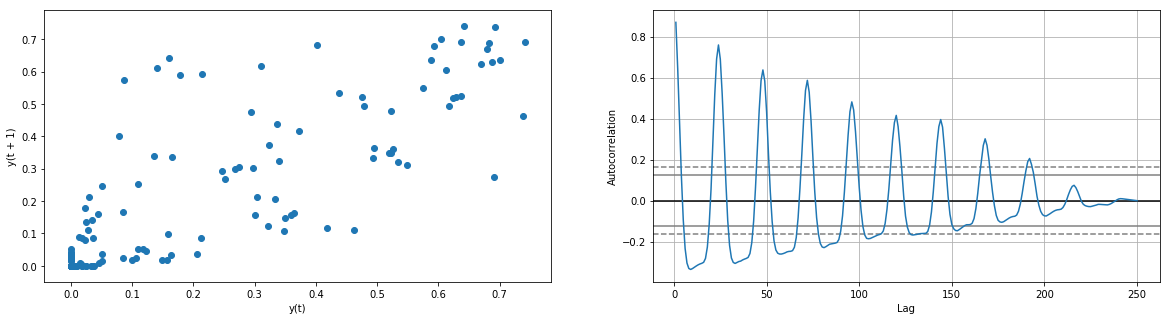

In [19]:
fig, ax = plt.subplots(1,2 ,figsize=(20,5))
lag_plot(df['POWER'].tail(250),ax=ax[0])
autocorrelation_plot(df['POWER'].tail(250),ax=ax[1])

## Többi feature kapcsolata a célváltozóval

Megnéztem egy két hetes időintervallumra, hogy hogy néznek ki az egyes változók.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000002AC1EA8358>,
      dtype=object)

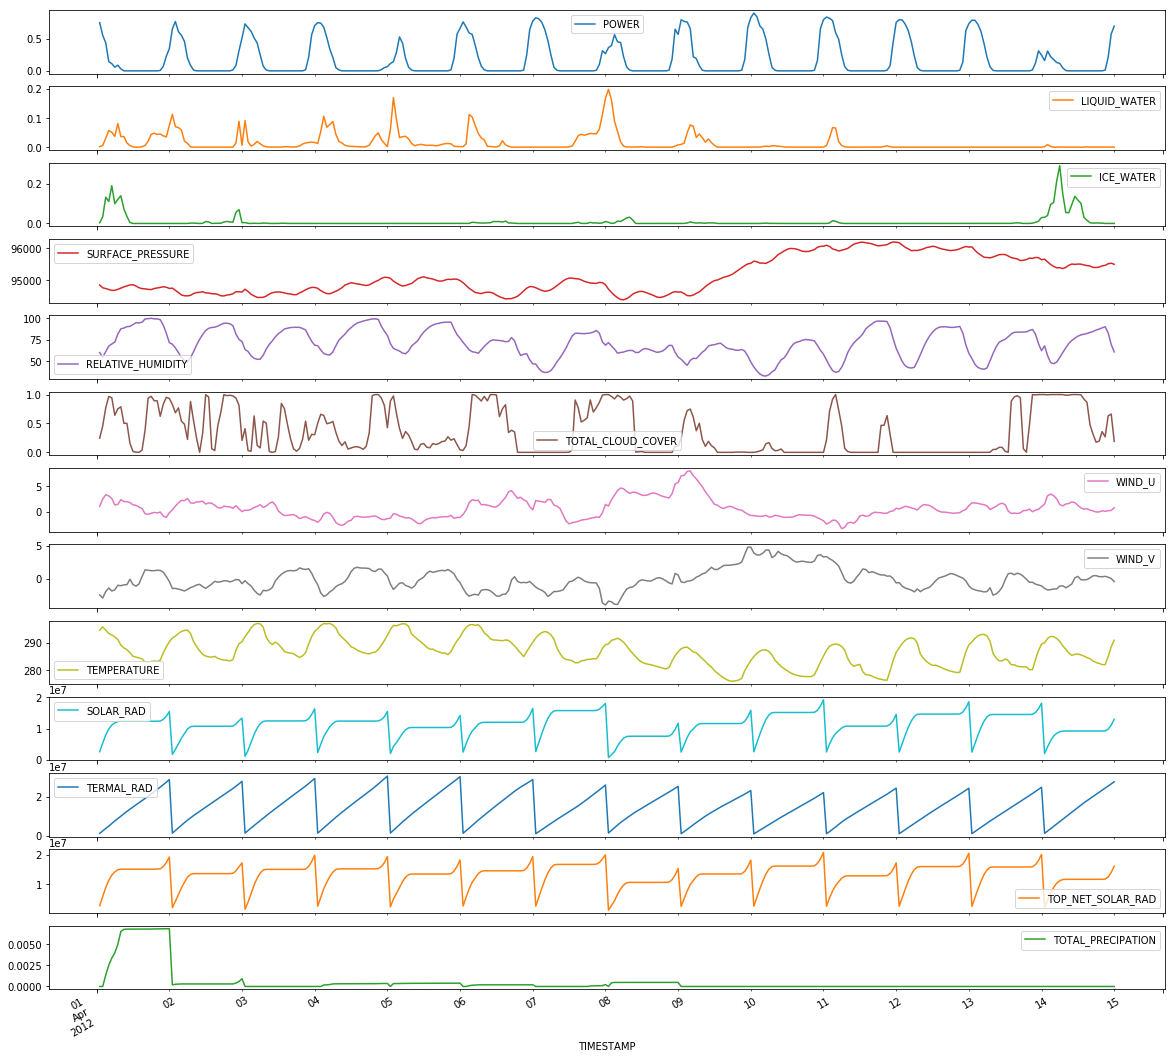

In [20]:
df[:ONE_WEEK*2].plot(subplots=True,figsize=(20,20))

### Ami ebből első ránézésre látszik: 
Ott voltak visszaesések a termelésben, ahol:
* sokat esett az eső
* nagy volt a felhőzet
Ami egész jelentéktelennek tűnik:
* széljárás
* páratartalom
Illetve látszik még, hogy az utolsó négy mező elég furcsán változik, ez azért van, mert ezek akkumlált mezők.

Szétbontottam az akkumlált mezőket.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000002AC1E77D68>,
      dtype=object)

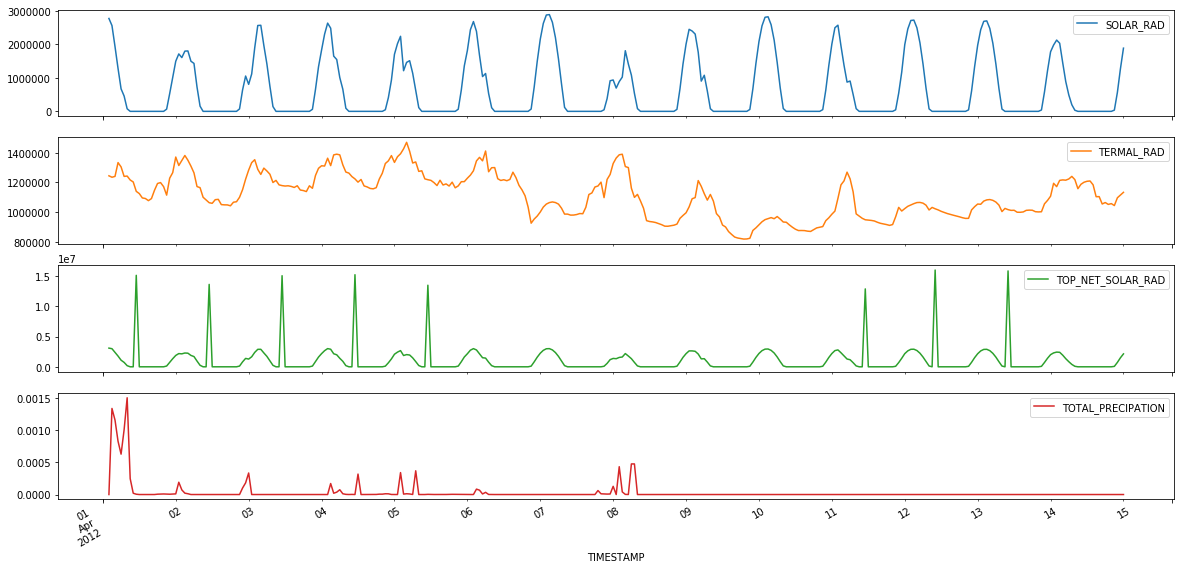

In [21]:
accumlated_columns = ["SOLAR_RAD","TERMAL_RAD","TOP_NET_SOLAR_RAD","TOTAL_PRECIPATION"]
def dissipate_features(df, columns):
    for column in columns:
        df[column] = df[column].rolling(window=2).apply(lambda x: x[1] if x[1] - x[0] < 0 else x[1] - x[0], raw='True')
    return df
df = dissipate_features(df=df, columns=accumlated_columns)
df[:ONE_WEEK*2][accumlated_columns].plot(subplots=True,figsize=(20,10))

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_scatters(df, target_column):
    number_of_columns = len(df.columns.values)
    plot_columns = 5
    whole_rows = int(number_of_columns / plot_columns)
    extrarow = 1 if number_of_columns % plot_columns > 0 else 0

    row = -1
    column = 0
    for i, col in enumerate(df.columns.values):

        last_number_of_columns = number_of_columns%plot_columns
        is_last_row = int(number_of_columns/plot_columns)*plot_columns <= i

        if(i%plot_columns == 0):
            row += 1
            column = 0
            if is_last_row:
                fig, ax = plt.subplots(1,last_number_of_columns,figsize=(20,4))
            else:
                fig, ax = plt.subplots(1,plot_columns,figsize=(20,4))
        else:
            column += 1
        df.plot(x=[col], y=[target_column], kind="scatter", ax = ax[column] )

Majd megnéztem milyen kapcsolat van a célváltozó és az egyes változók között.

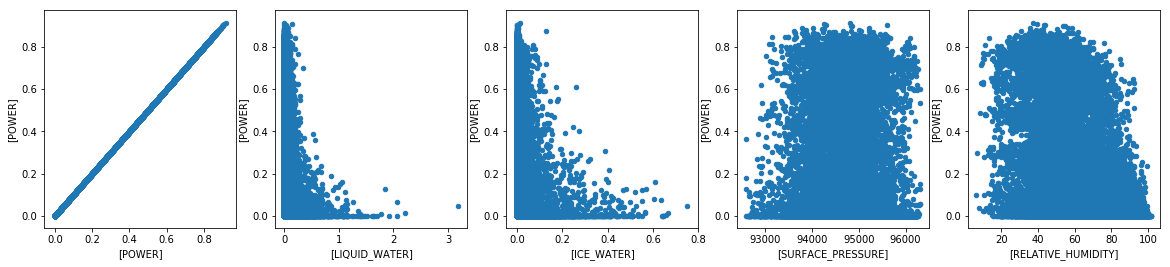

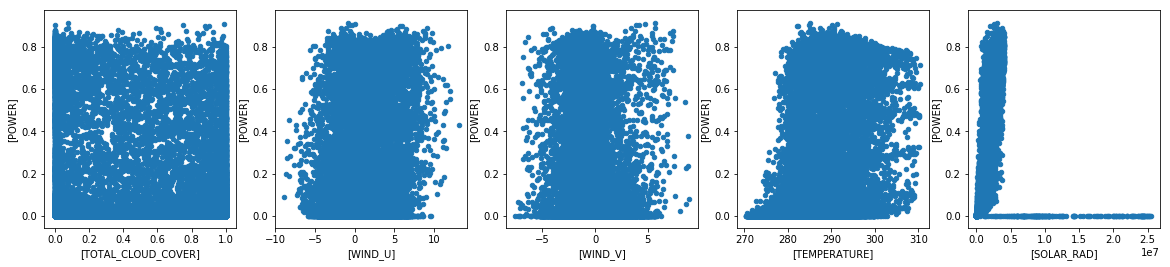

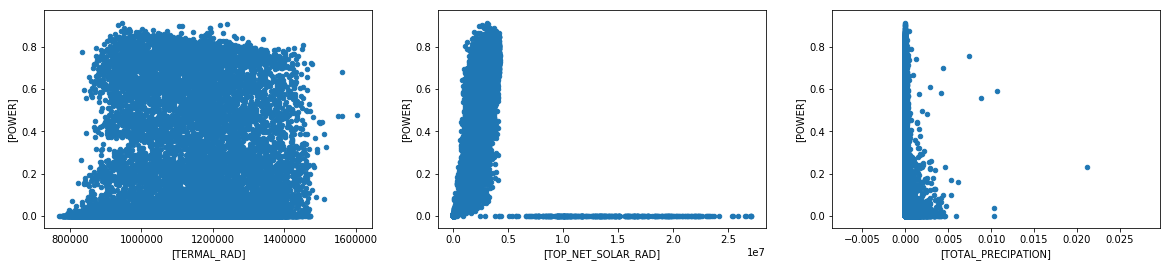

In [23]:
plot_scatters(df, "POWER")

### Amit innen meg tudok állapítani:
* Általában keveset esik az eső, de amikor esik, gyakoribbak az alacsony termelési értékek. Ehhez meg lehetne adni mondjuk egy kategorikus változót, ha egy adott értéknél többet esett az eső.
* A előbbi megállapítás igaz a jég formájú esőre és a teljes csapadékmennyiségre is.
* A napsugárzás mezőkben valószínüleg sok outlier van, mert ilyen magas napsugárzás értékekre 0 termelés elég elképzelhetetlen, de érdemes megnézni, hogy ez milyen időpontokban volt. 

Nézzük akkor a magas napsugárzás értékeknél mi történhetett.

Milyen órákban nincs termelés általában

In [24]:
df["HOUR"] = df.index.hour
df["MONTH"] = df.index.month

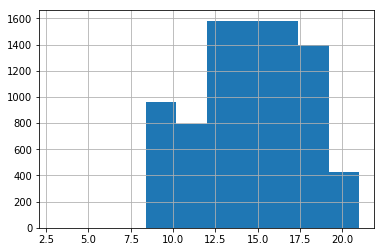

In [25]:
df[df["POWER"] == 0].HOUR.hist()

9 és 21 óra között nincsen termelés leggyakrabban

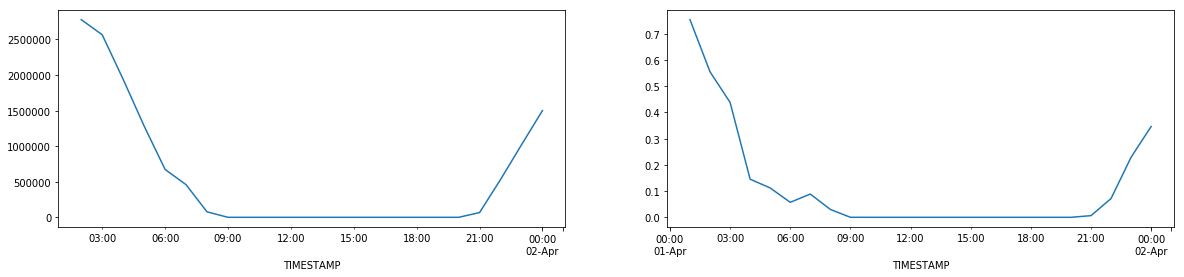

In [26]:
fig, ax = plt.subplots(1,2,figsize=(20,4))
df.SOLAR_RAD[:ONE_DAY].plot(ax=ax[0])
df.POWER[:ONE_DAY].plot(ax=ax[1])

Napsugázásra is igaz, hogy 9 és 21 óra között 0

Nézzük, hogy a legmagasabb napsugárzás milyen időpontokban van.

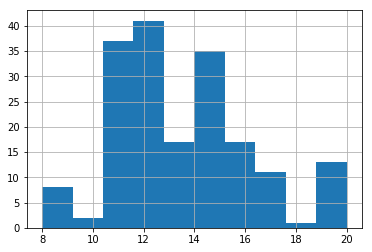

In [27]:
mask = (df["SOLAR_RAD"]>0.5*pow(10,7))
df_outlier = df[mask]
df_outlier["HOUR"] = df_outlier.index.hour
df_outlier["HOUR"].hist()

Ebből az látszik, hogy főleg 11 és 17 között jelenik meg, ami biztos nem jó, mivel akkor van éjszaka.

In [28]:
print("{0} darab értékünk van összesen, ebből {1} darab biztosan outlier.".format(len(df),len(df_outlier)))

18984 darab értékünk van összesen, ebből 182 darab biztosan outlier.


Nézzük máshogy, nézzük 

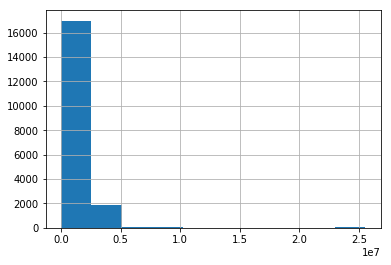

In [29]:
mask = (df["HOUR"]<9)  | (df.HOUR | 21)
df[mask]["SOLAR_RAD"].hist()

Ebből, látszik, hogy máshol is van pár irreálisan magas érték.

Felvettem a szezonalitás szerint szétbontott mezőket

In [30]:
df["RESID"] = seasonal_decompose(df.POWER).resid
df["SEASONAL"] = seasonal_decompose(df.POWER).seasonal
df["TREND"] = seasonal_decompose(df.POWER).trend

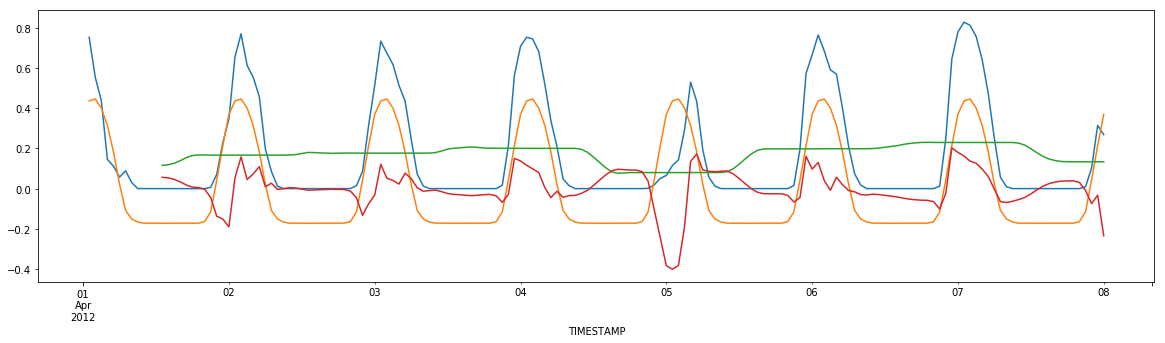

In [31]:
df.POWER[:ONE_WEEK].plot(figsize=(20,5))
df.SEASONAL[:ONE_WEEK].plot(figsize=(20,5))
df.TREND[:ONE_WEEK].plot(figsize=(20,5))
df.RESID[:ONE_WEEK].plot(figsize=(20,5))

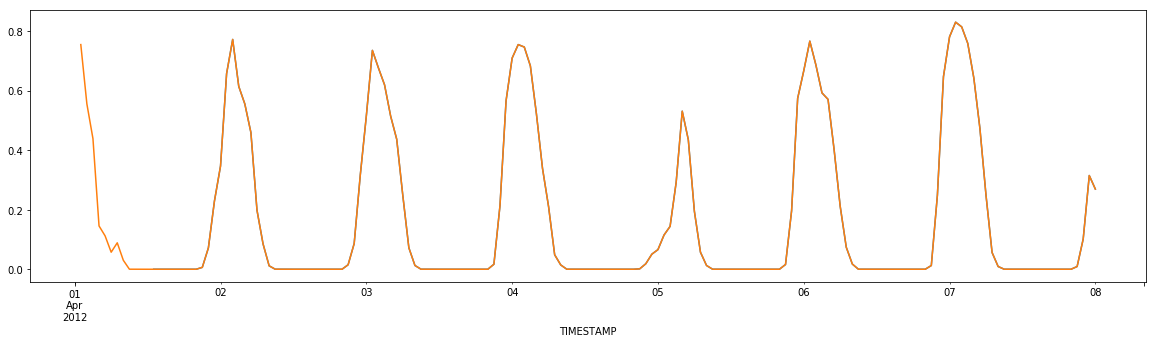

In [32]:
ORIG = df["RESID"]+df["SEASONAL"]+df["TREND"]
ORIG[:ONE_WEEK].plot(figsize=(20,5))
df.POWER[:ONE_WEEK].plot(figsize=(20,5))

Ebből biztosan látszik, hogy a resid, seasonal és trend mezők összege visszaadja az eredeti függvényt.

Megnéztem a korrelációt az összes mező között

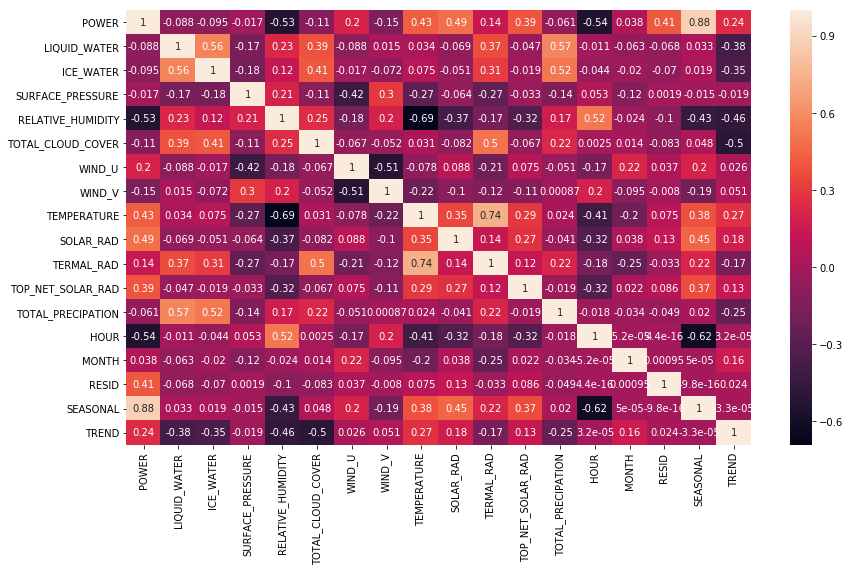

In [33]:
fig, ax = plt.subplots(figsize=(14,8))         # Sample figsize in inches

f = (
    df.loc[:, df.columns]
        
).corr()

sns.heatmap(f, annot=True, ax=ax)

Innen látszik, hogy az összes eredeti feature közül legjobban a relatív páratartalom, a hőmérsékelet és a napsugárzás korrelálnak a célválztozóval.

Az általam létrehozottak közül pedig a szezonalitás.

Az ötletem az lenne hogy a szezonalitást függvényként tárolom majd, így minden időponthoz kiszámolható. Gépi tanulással pedig a residual és talán a trend komponenseket predictelem.

In [34]:
df["RT"] = df["SEASONAL"] + df["RESID"]

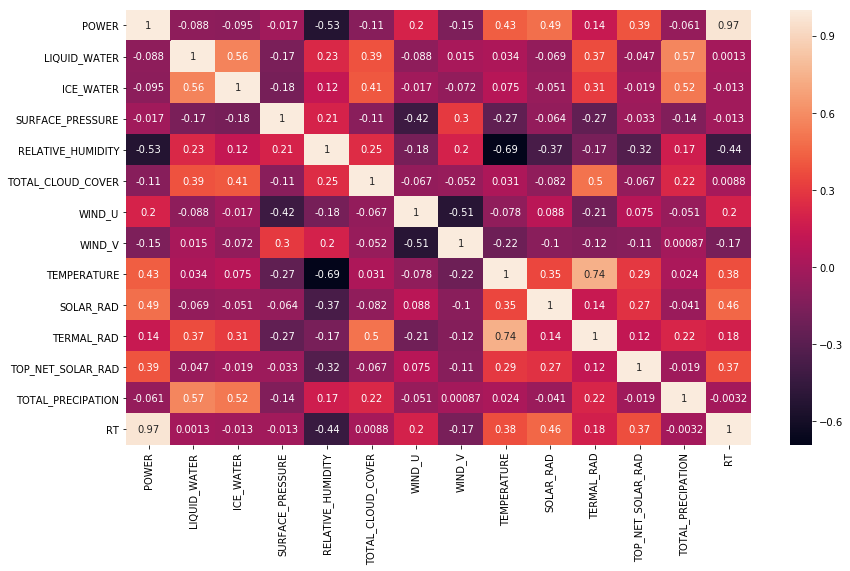

In [35]:
df_to_plot = df.drop(["SEASONAL","HOUR","MONTH","RESID","TREND"],axis=1)
fig, ax = plt.subplots(figsize=(14,8))         # Sample figsize in inches

f = (
    df_to_plot.loc[:, df_to_plot.columns]
        
).corr()

sns.heatmap(f, annot=True, ax=ax)

Relatív páratartalom, napsugárzás és hőmérséklet amik fontosabbak.

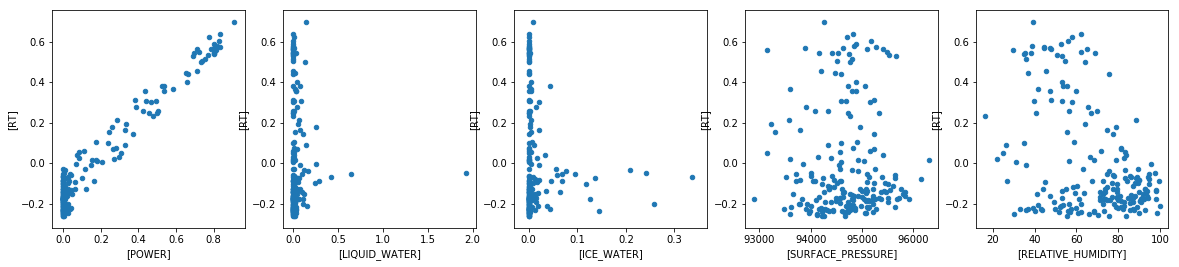

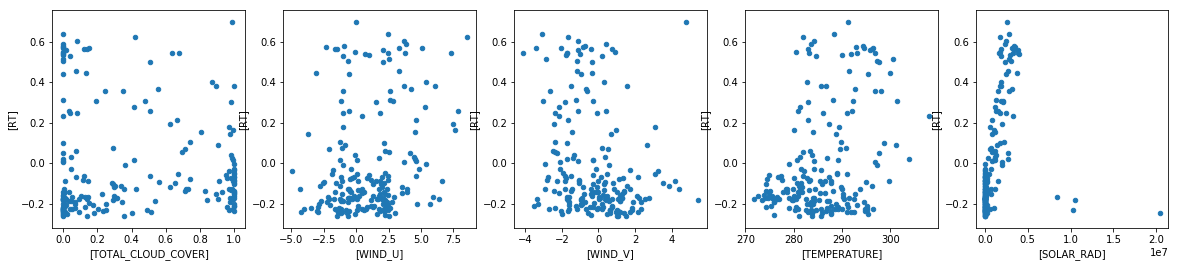

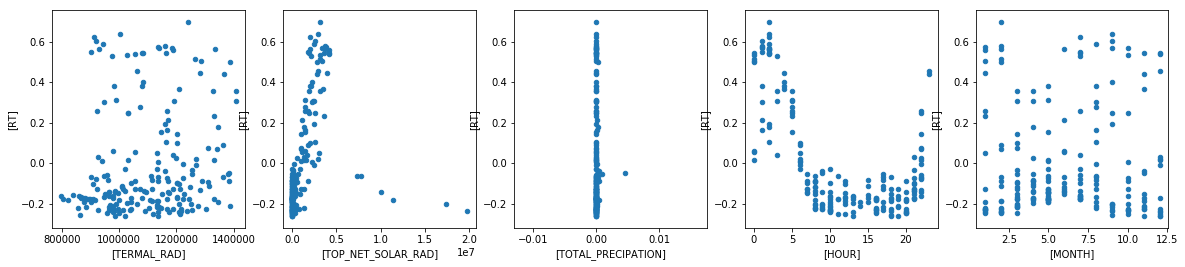

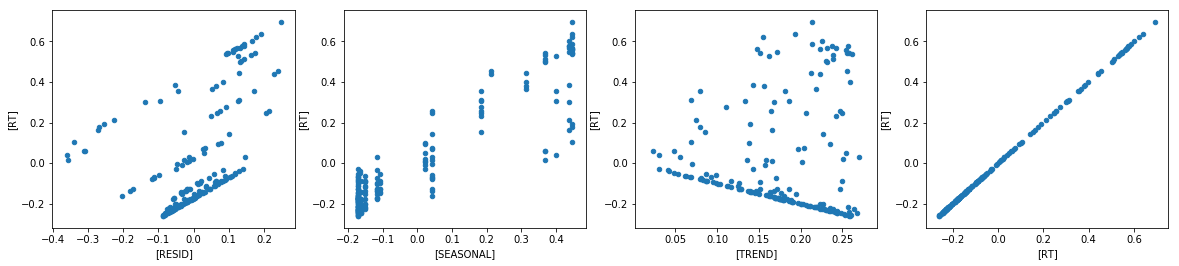

In [36]:
plot_scatters(df.sample(200),"RT")

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_lags_and_auto(df):
    columns = len(df.columns)
    for col in df.columns:
        fig, ax = plt.subplots(1,2,figsize=(20,5))
        fig.suptitle(col, fontsize=16)
        lag_plot(df[col].tail(250),ax =ax[0])
        autocorrelation_plot(df[col].tail(250), ax = ax[1])

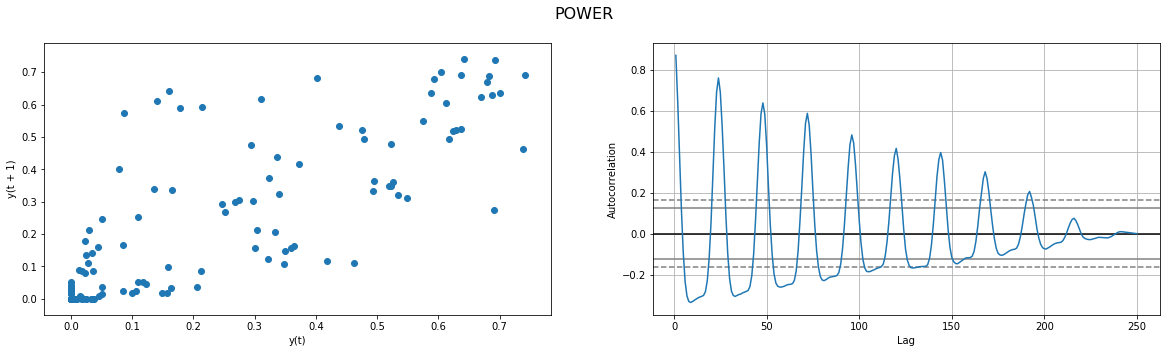

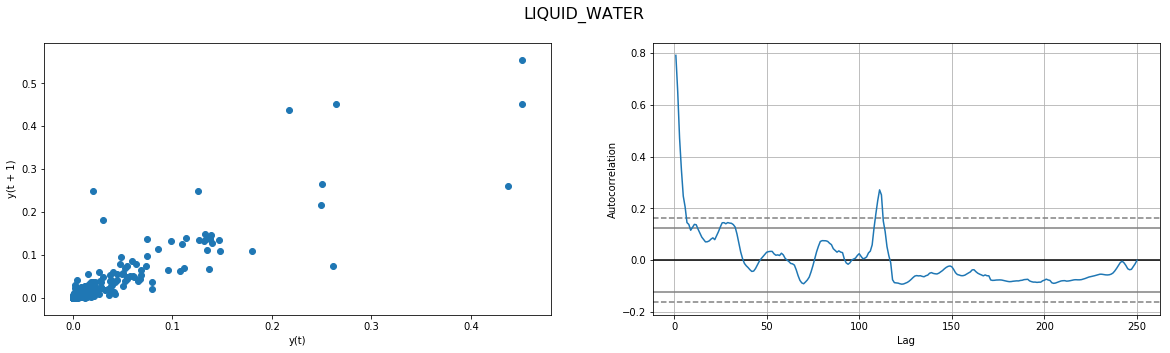

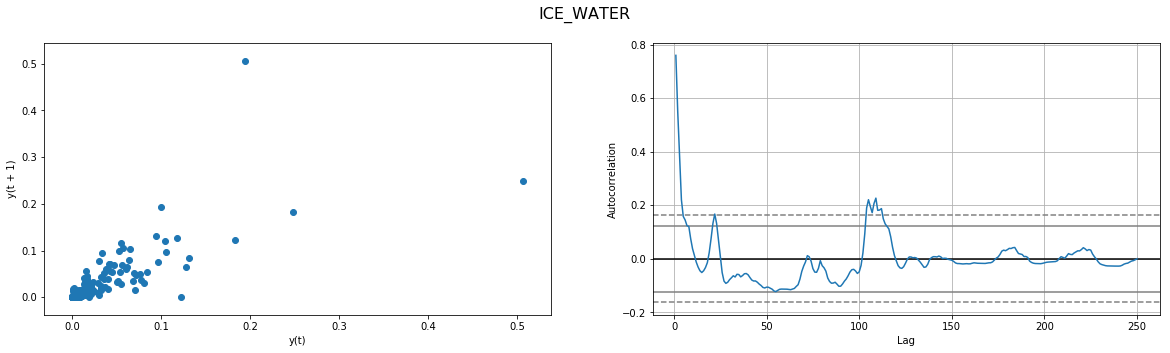

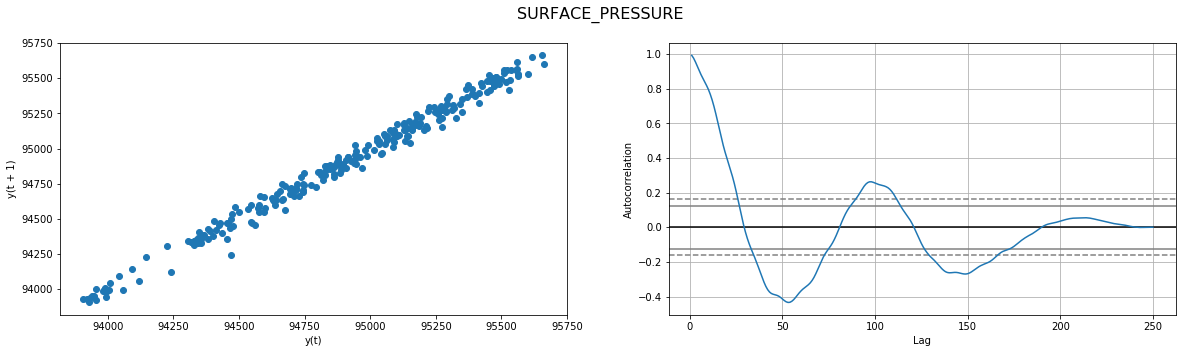

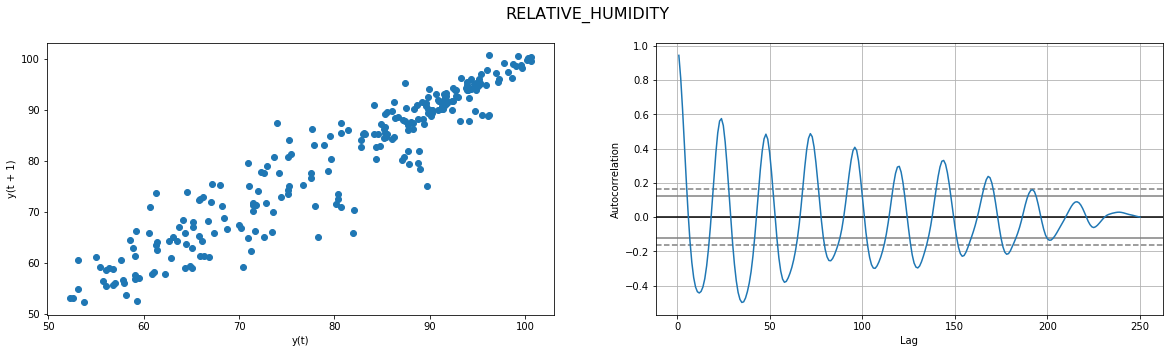

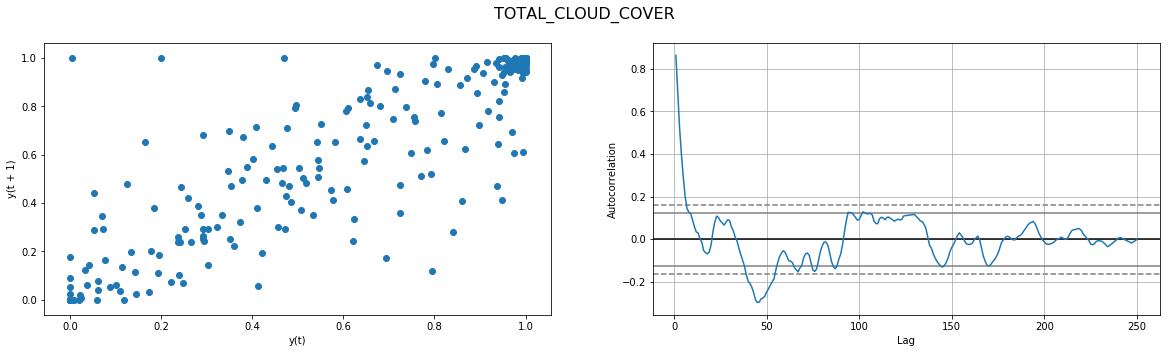

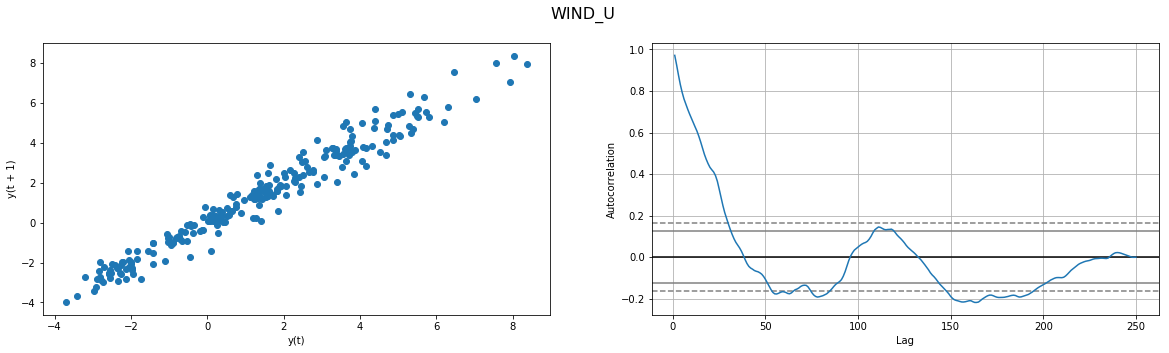

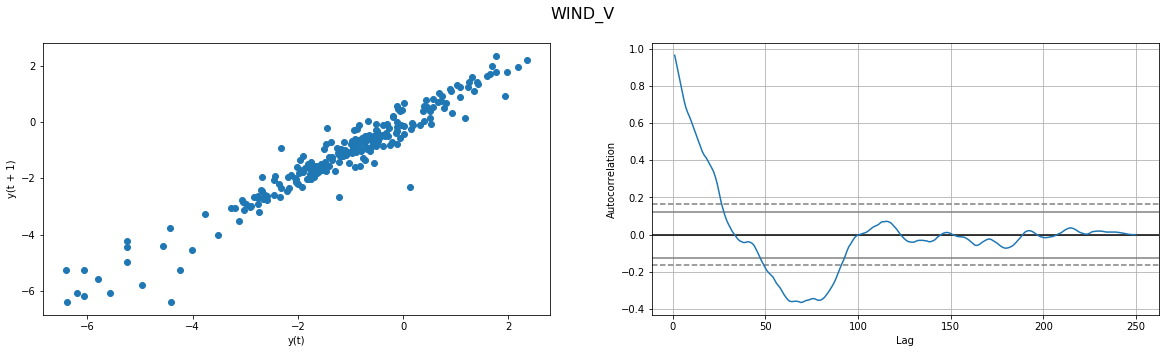

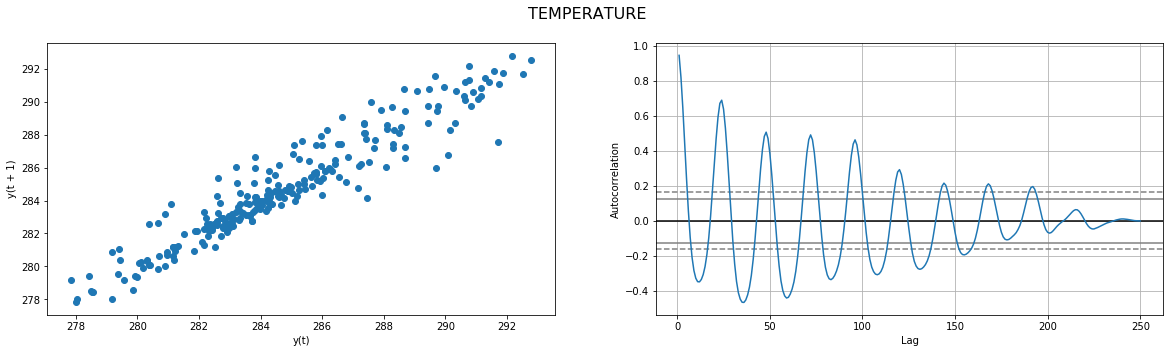

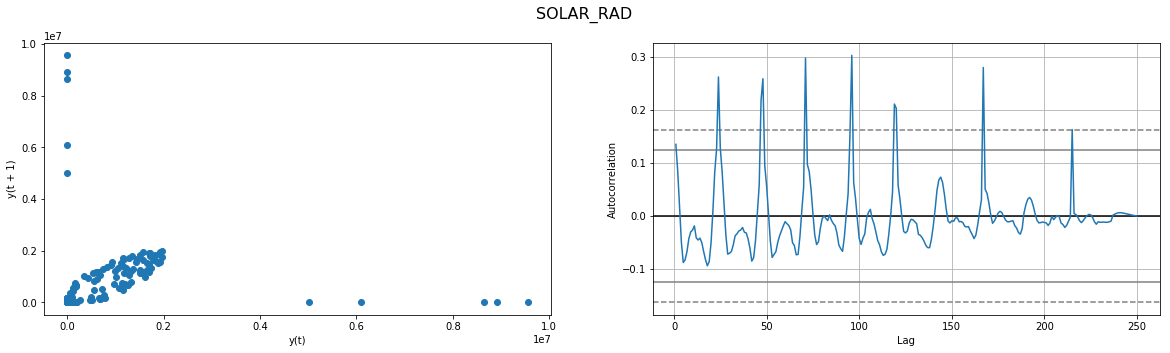

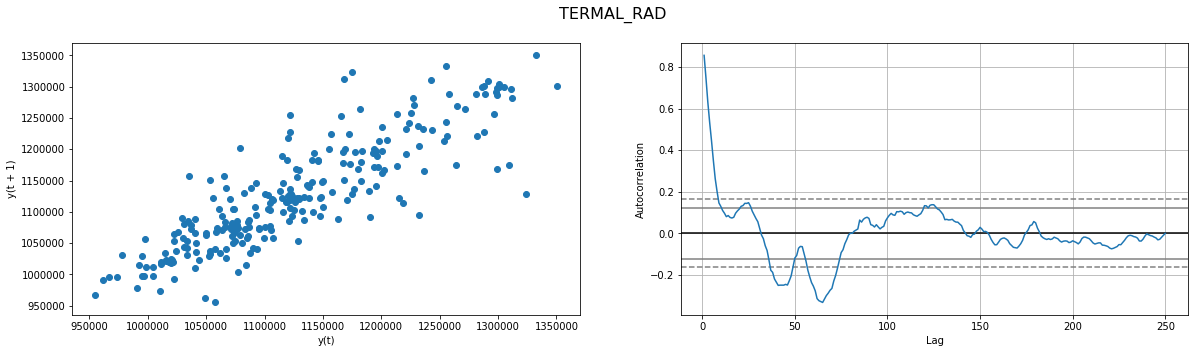

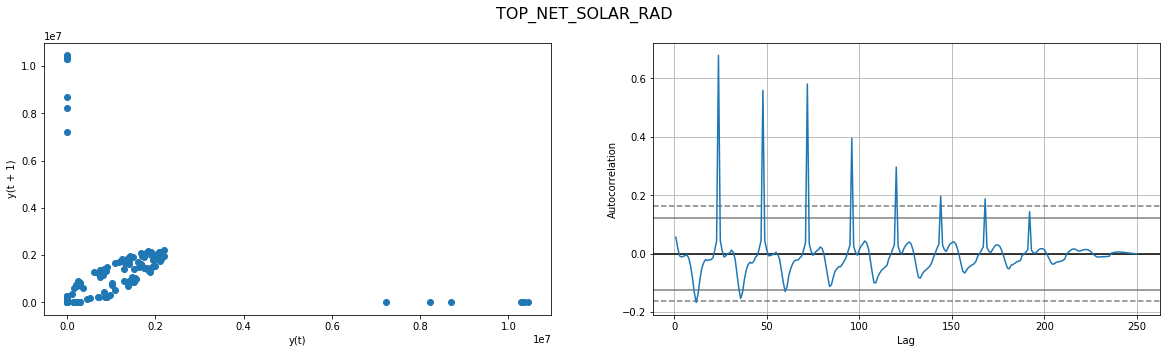

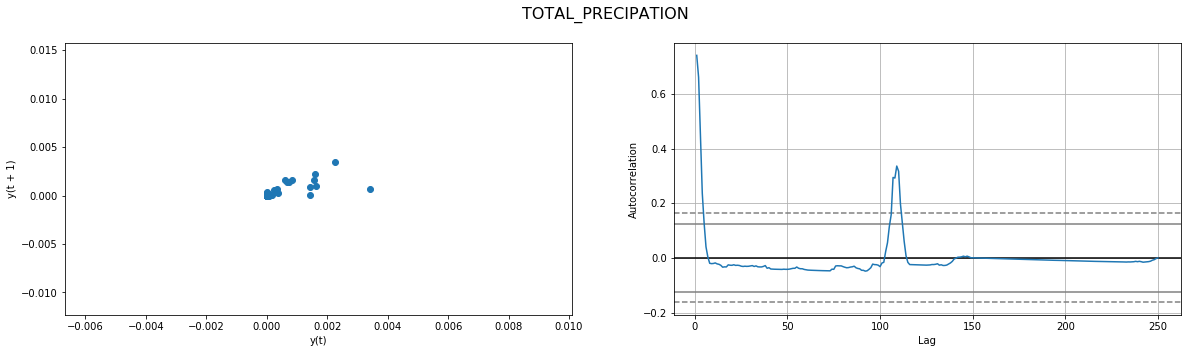

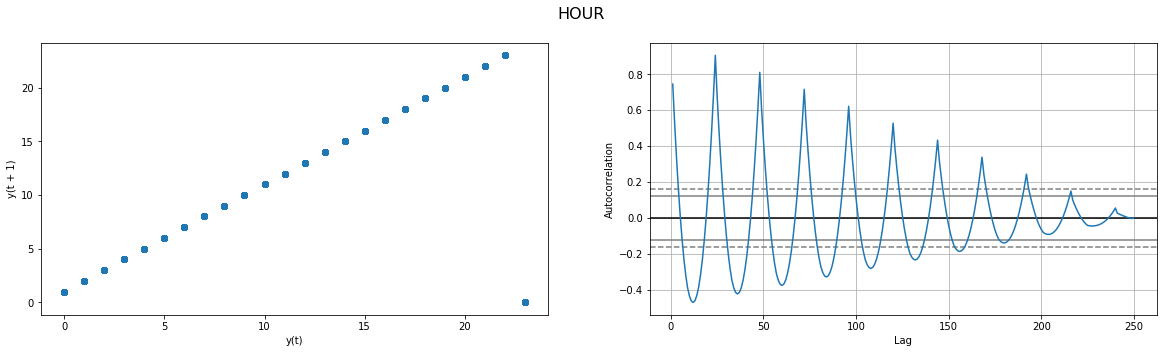

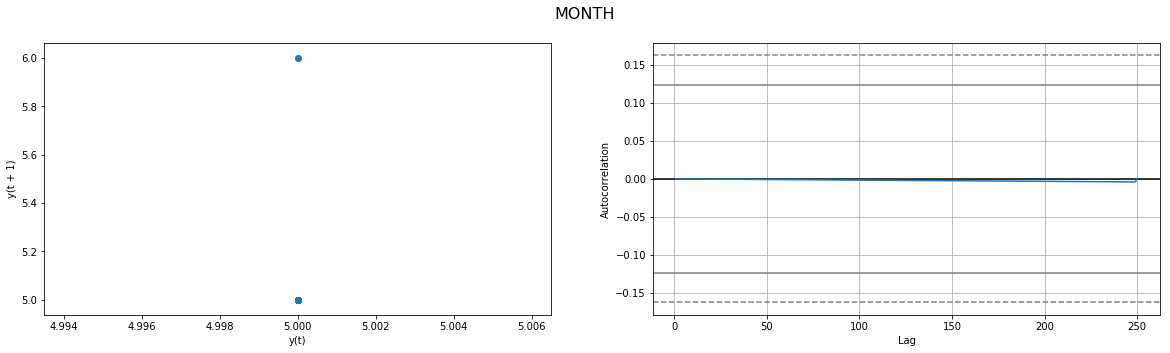

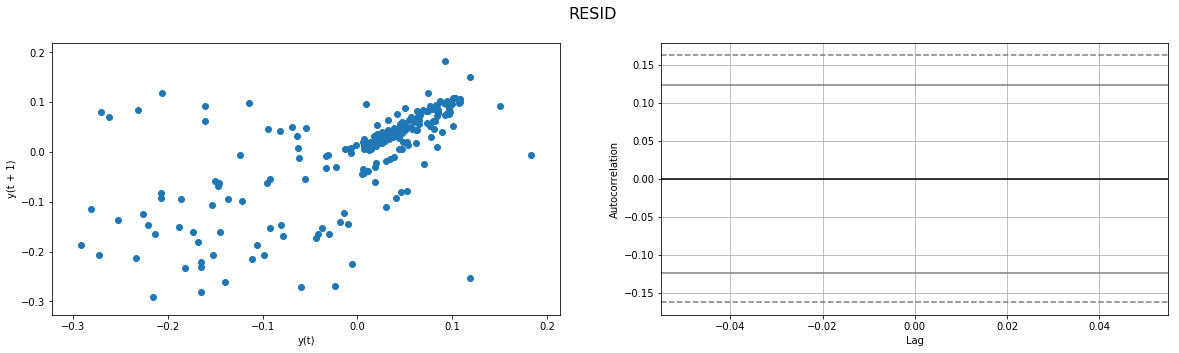

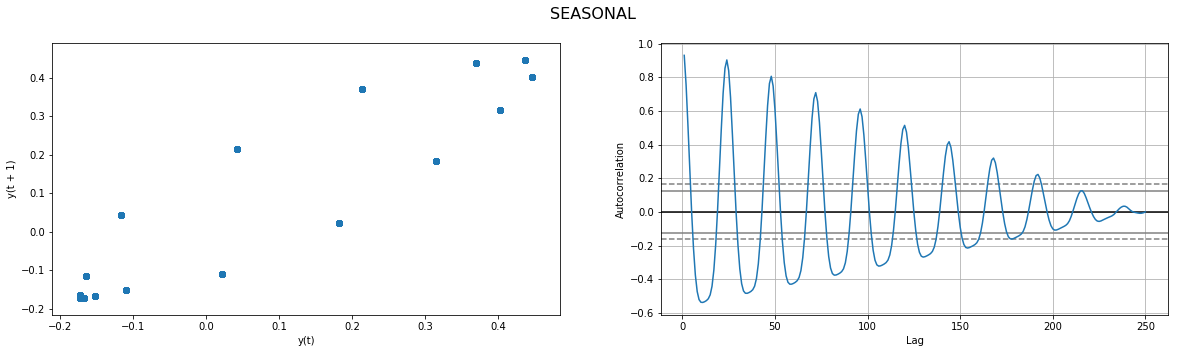

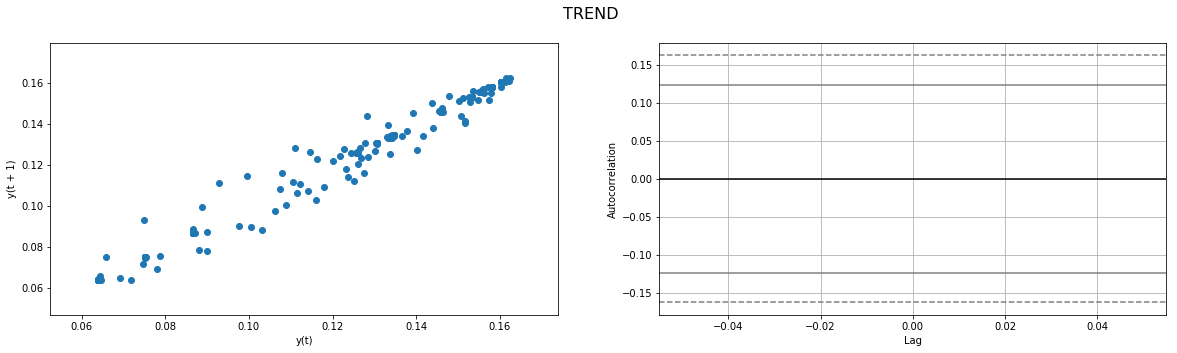

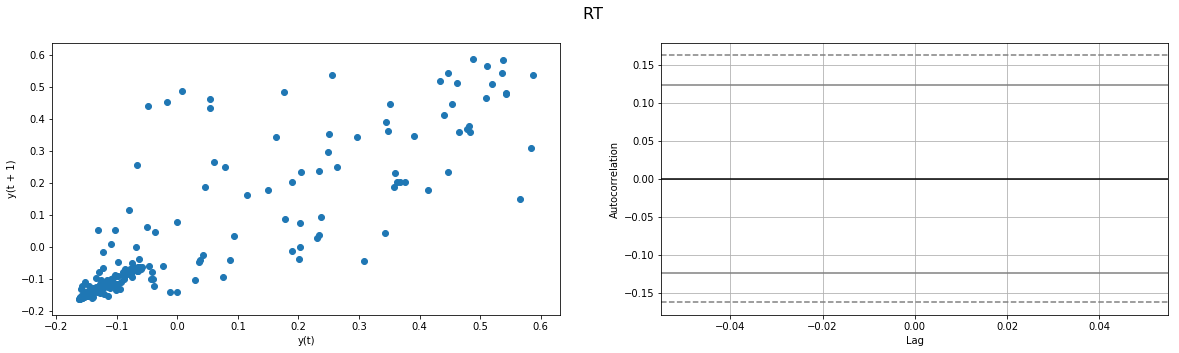

In [38]:
plot_lags_and_auto(df)

Innen azok a mezők használhatóak csak, amiknek 24 lag után is viszonylag erős autokorrelációjuk van.
Ezek pedig:
* Surface pressure
* Relative humidity
* WIND U
* WIND V
* Temperature

Ezek alapján amiket fel fogok használni featureként azok a surface pressure és a temperature. Illetve a célváltozót is.

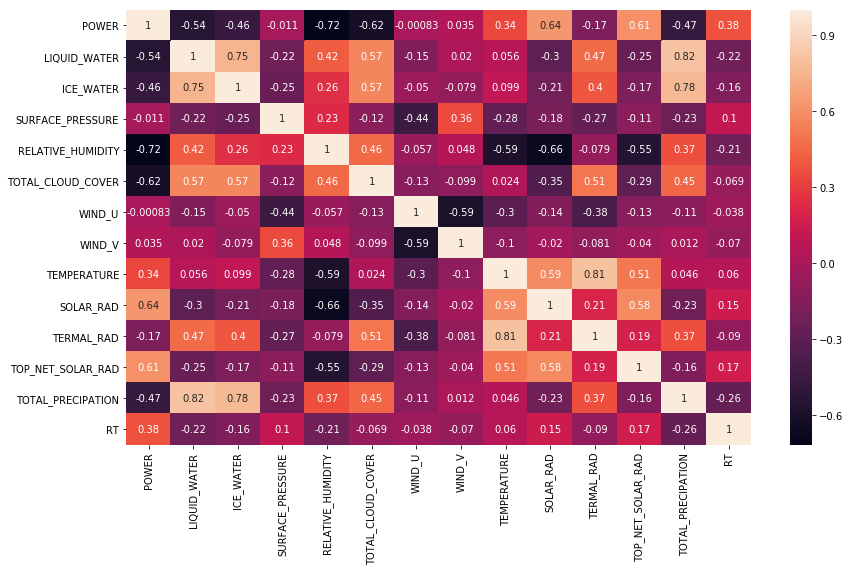

In [39]:
df_to_plot = df.drop(["SEASONAL","HOUR","MONTH","RESID","TREND"],axis=1).resample('D').mean()
fig, ax = plt.subplots(figsize=(14,8))         # Sample figsize in inches

f = (
    df_to_plot.loc[:, df_to_plot.columns]
        
).corr()

sns.heatmap(f, annot=True, ax=ax)

Később talán az esőt is beleveszem, illetve a felhőtakarót. 

Rolling apply segítségével létrehozom a mozgó átlagot 24 órás ablakra a fennt említett mezőkhöz.

In [40]:
df_to_train = df[["POWER","SURFACE_PRESSURE","TEMPERATURE","HOUR","MONTH"]]
for column in ["POWER","SURFACE_PRESSURE","TEMPERATURE"]:
    rolling_column = df_to_train[column].rolling(window = 24)
    shift = 24
    df_to_train["ROLLING_MEAN_"+column] = rolling_column.mean().shift(shift)
    df_to_train["ROLLING_MAX_"+column] = rolling_column.max().shift(shift)
    df_to_train["ROLLING_SUM_"+column] = rolling_column.sum().shift(shift)
    df_to_train["ROLLING_MEDIAN_"+column] = rolling_column.median().shift(shift)
    df_to_train["ROLLING_STD_"+column] = rolling_column.std().shift(shift)
    df_to_train["ROLLING_VAR_"+column] = rolling_column.var().shift(shift)

X_train = df_to_train[:ONE_YEAR].dropna(axis = 0).drop(["POWER","SURFACE_PRESSURE","TEMPERATURE"],axis=1)
y_train = df_to_train[:ONE_YEAR].dropna(axis = 0).POWER
X_test = df_to_train[ONE_YEAR:].dropna(axis = 0).drop(["POWER","SURFACE_PRESSURE","TEMPERATURE"],axis=1)
y_test = df_to_train[ONE_YEAR:].dropna(axis = 0).POWER
#print(len(df_to_train))
#print(len(df_to_train.dropna(axis=0)))

Először, a power-re predictelek, mert a szezonalitást még nem tudom hogy tároljam le.

In [41]:
from sklearn.metrics import mean_squared_error,explained_variance_score
def train_predict_and_score(X_train, y_train,X_test,y_test,models,names):
    for name,model in zip(names,models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fig, ax = plt.subplots(figsize=(10,5))
        fig.suptitle("{0}\nMSE:{1} | EVS:{2}".format(name,mean_squared_error(y_test,y_pred),explained_variance_score(y_test,y_pred)), fontsize=12)
        sns.kdeplot(y_test)
        sns.kdeplot(y_pred)

D:\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


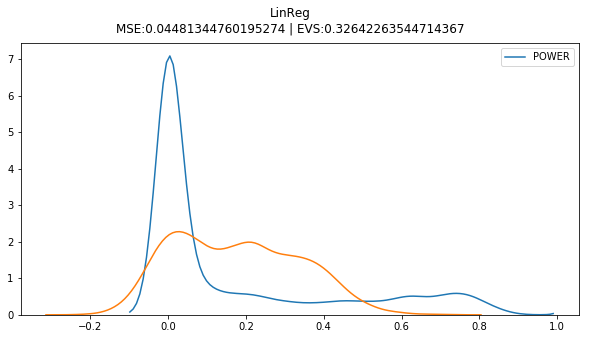

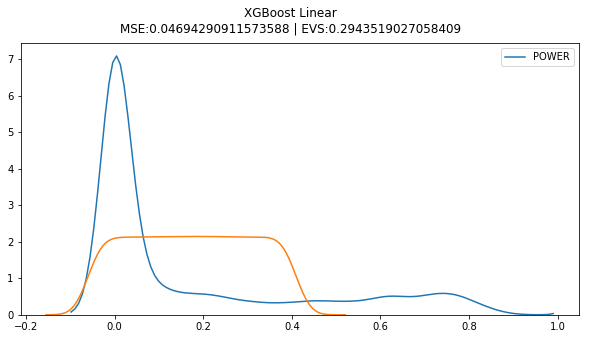

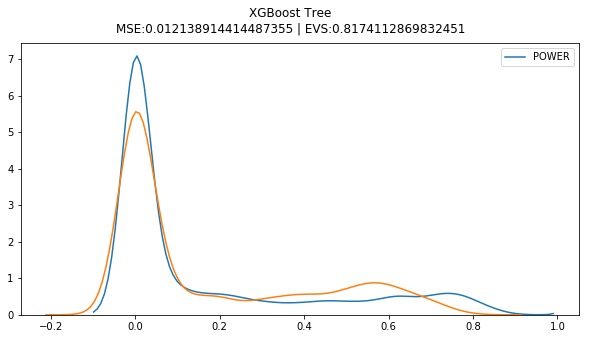

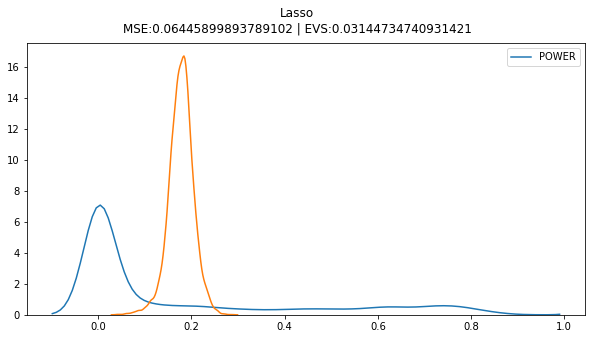

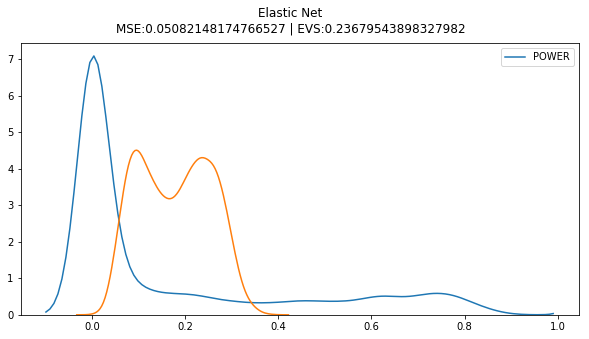

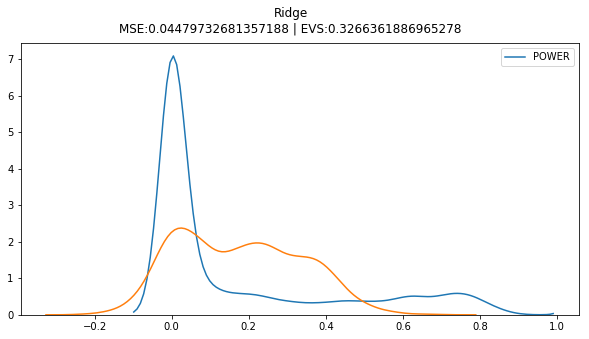

In [43]:
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso,ElasticNet,Ridge,LinearRegression
from sklearn.svm import SVR,LinearSVR
names=["LinReg","XGBoost Linear", "XGBoost Tree", "Lasso","Elastic Net","Ridge"]
models = [LinearRegression(),XGBRegressor(booster='gblinear'),XGBRegressor(),Lasso(),ElasticNet(),Ridge()]
train_predict_and_score(X_train,y_train,X_test,y_test,models,names)

Ez alapján az XGBoost tűnik a leghatékonyabbnak.

## Amit lehetné még meg kell csinálni/javítani kell: 
* Megcsinálni a többi zónára is
* Jobb Feature selection
* Algoritmusok paraméterezése
* Tényleg csak a residual-t predictelni és összeadni a seasonality-vel
* A napsugárzás változóból kidobálni az outliereket és felhasználni
* Más rolling window értékek kipróbálása. Bár szerintem 48 óránál nagyobb nem nagyon jön szóba.
* ARIMA modell implementálása